# 2D cell-tracking with Ultrack and Stardist

The goal of this document is to present Ultrack's programming interface.
We use Stardist for segmentation because its available weights are reliable for 2D nuclei segmentation.
However, any algorithm other could be used or even multiple segmentation masks are allowed.

The tracking procedure can be roughly divided into two stages:
- Obtaining cell detections and their boundaries (e.g. edges);
- Compute tracking from detection and edges.

First, we download demostration dataset from cell-tracking challenge.

In [1]:
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip
!unzip -n Fluo-N2DL-HeLa.zip

File ‘Fluo-N2DL-HeLa.zip’ already there; not retrieving.

Archive:  Fluo-N2DL-HeLa.zip


We set some environment variables and import the required python packages.

In [2]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pathlib import Path

import napari
import numpy as np
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist2D

from ultrack import segment, link, track, to_tracks_layer, tracks_to_zarr
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.config import MainConfig

2022-09-30 14:30:18.474717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 14:30:18.588843: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 14:30:19.040053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/home/jordao/Softwares/gurobi912/linux64/lib
2022-09-30 14:30:19.040117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

## 1. Computing cell detection and boundaries

We implement two helper functions, one for normalizing the data as expected by the neural network model and another one for computing the network prediction.

In [3]:
def normalize(arr: np.ndarray) -> np.ndarray:
    """Normalizes an array to values between (0, 1)"""
    arr = np.asarray(arr)
    arr = np.sqrt(arr)
    arr = arr - np.quantile(arr, 0.001)
    arr = arr / np.quantile(arr, 0.999)
    arr = np.clip(arr, 0, 1)
    return arr

def predict(image: np.ndarray, model: StarDist2D) -> np.ndarray:
    """Normalizes the image per frame and computes stardist prediction"""
    labels = np.zeros_like(image, dtype=np.int32)
    for t in tqdm(range(labels.shape[0]), "Predicting labels"):
        frame = normalize(image[t])
        labels[t], _ = model.predict_instances_big(
            frame, "YX", block_size=560, min_overlap=96, show_progress=False,
        )
    return labels

We set the download dataset path, open a napari viewer and open the images using napari's default reader.

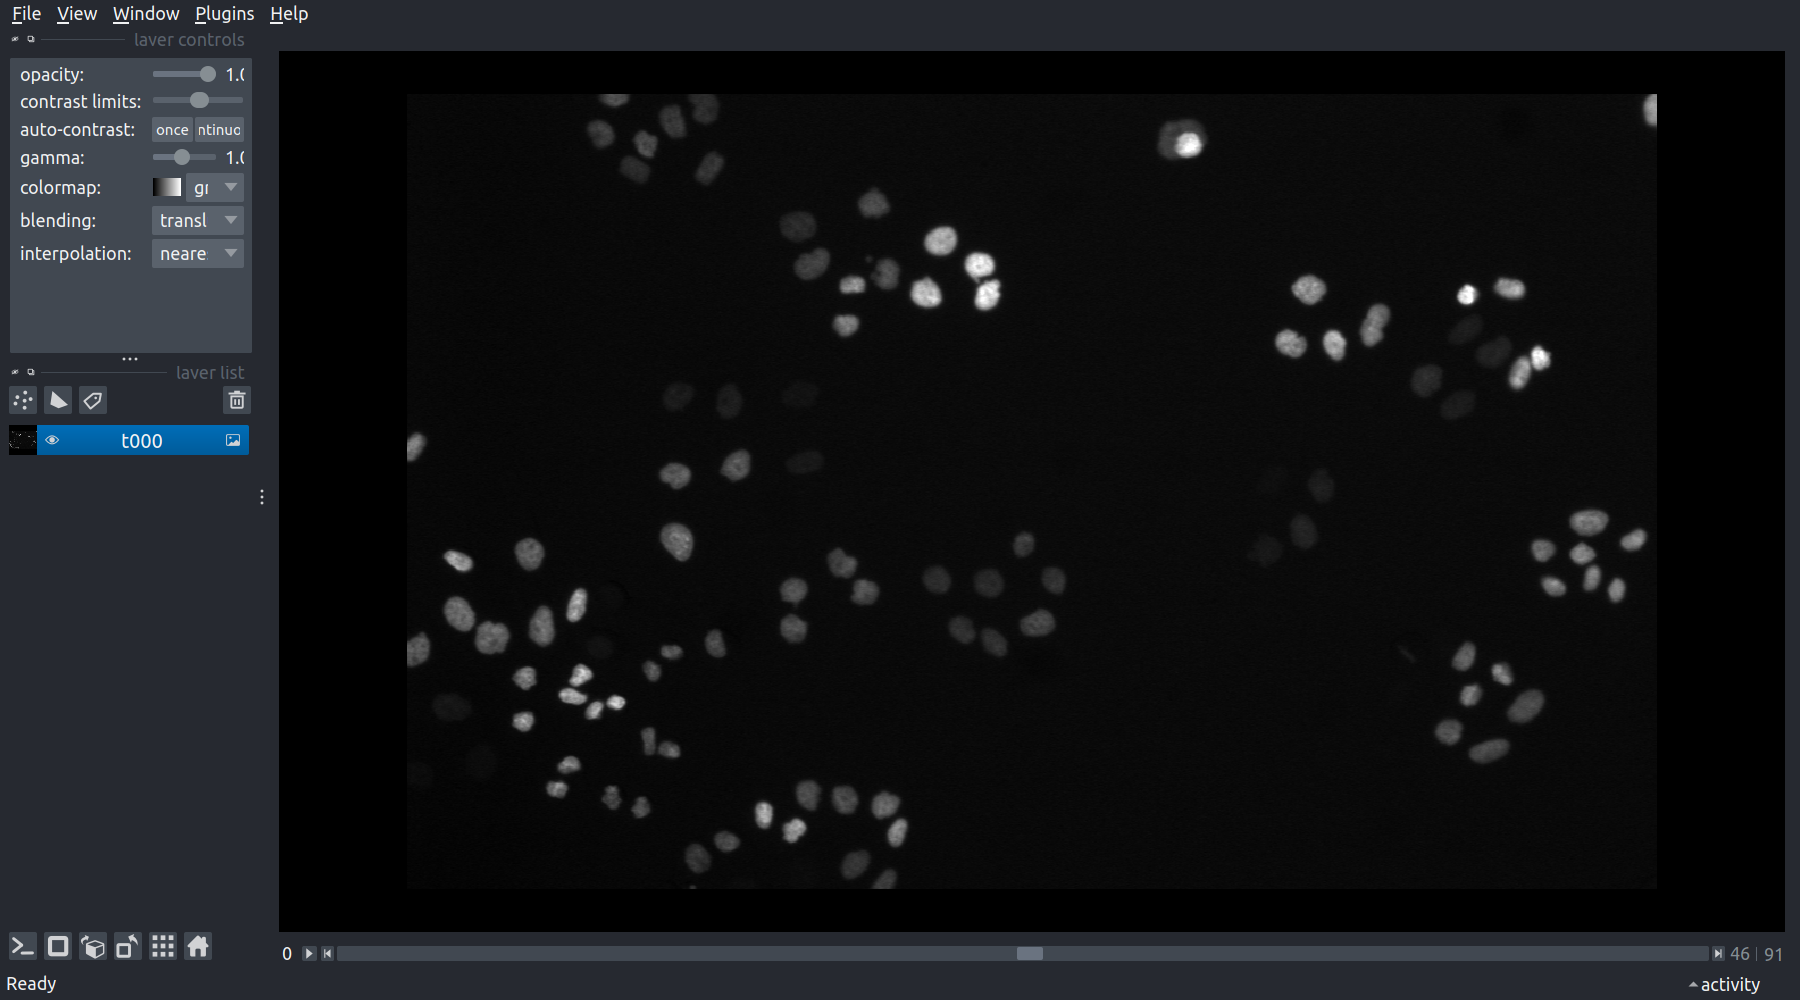

In [4]:
dataset_path = Path("Fluo-N2DL-HeLa/01")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*.tif")), stack=True)

nbscreenshot(viewer)

Using the `predict` helper function we compute the Stardist results.

In [5]:
%%capture
model = StarDist2D.from_pretrained("2D_versatile_fluo")
stardist_labels = predict(viewer.layers[0].data, model)

viewer.add_labels(stardist_labels, name="stardist")

2022-09-30 14:30:24.791257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 14:30:24.791687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 14:30:24.791799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 14:30:24.792092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

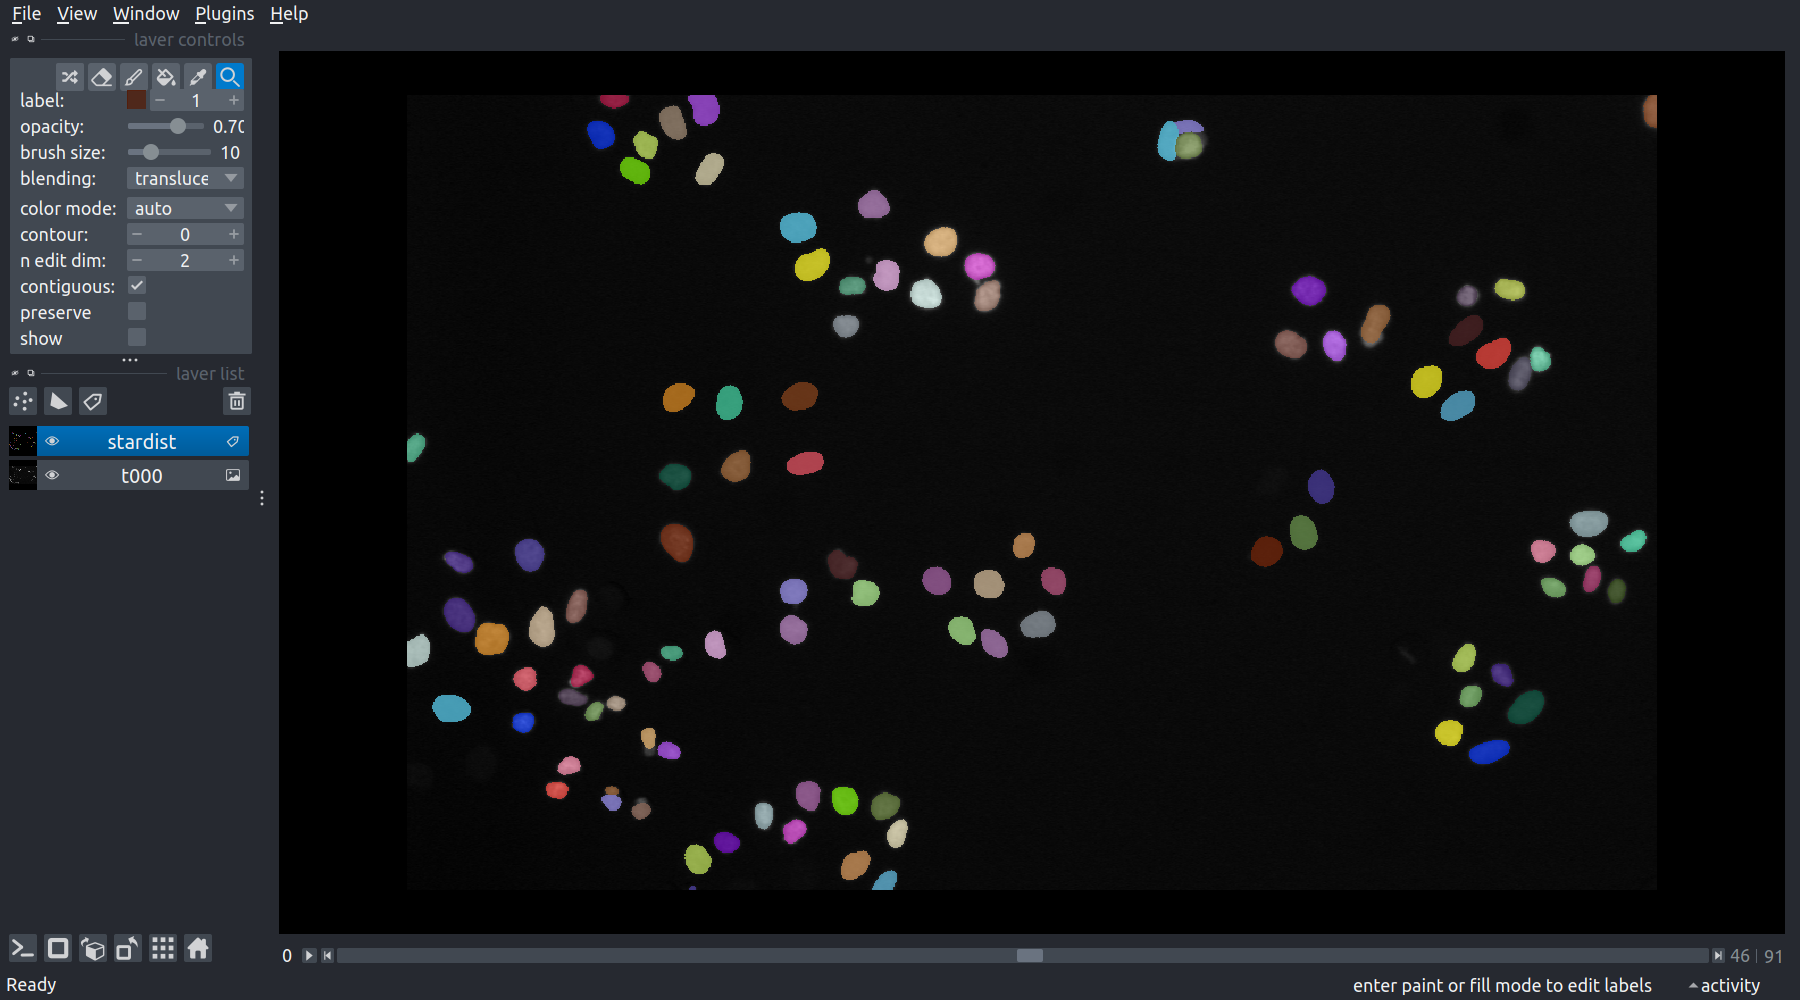

In [6]:
nbscreenshot(viewer)

The `labels_to_edges` converts labels into Ultrack's expected input, a detection and edges maps (cells' boundaries)

In [7]:
detection, edges = labels_to_edges(stardist_labels, sigma=4.0)  # multiple labels can be used with [labels_0, labels_1, ...]

Converting labels to edges: 100%|█| 92/92 [00:04<00:00, 20


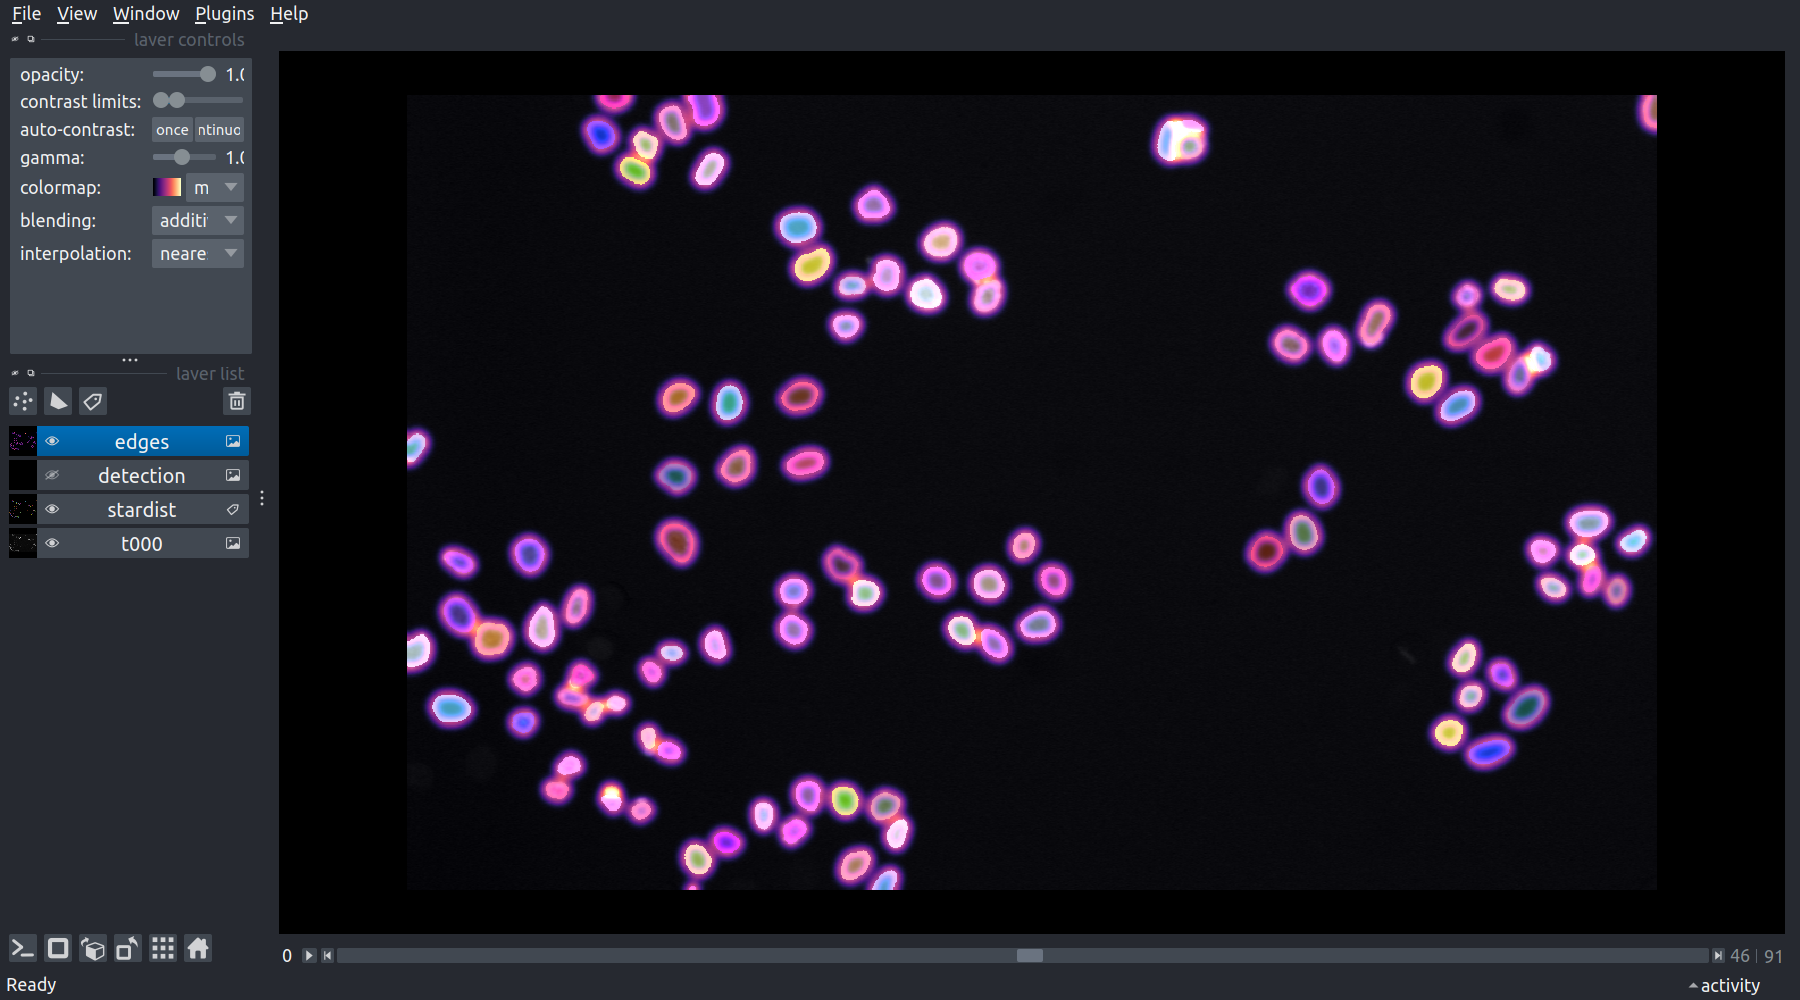

In [8]:
viewer.add_image(detection, visible=False)
viewer.add_image(edges, blending="additive", colormap="magma")
nbscreenshot(viewer)

## 2. Tracking

Now that we have our `detection` and `edges`, we will start the tracking step.
Ultrack's tracking relies on 3 steps and their respective python functions:
- `segment`: Computes the segmentation hypothesis for tracking;
- `link`: Links and assign edge weights to the segmentation hypothesis;
- `track`: Solves the tracking problem by selecting the strongly connected segmentation hypothesis.

All of these steps require their own configuration, which we'll set up below. It's documentation can be found [here TODO](https://www.duckduckgo.com).

We create our configuration instance and print its default values.

In [9]:
config = MainConfig()
pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite'),
│   reader_config=ReaderConfig(reader_plugin='builtins', layer_indices=[0, 1]),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7fc554423280>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(n_workers=1, max_neighbors=10, max_distance=15.0),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.5,
│   │   disappear_weight=-0.75,
│   │   division_weight=-1.0,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=-1,
│   │   n_threads=0,
│   │   link_function='power',
│   │   power=1,
│   │   bias=-0.005
│   )
)

To assist setting the parameters we inspect Stardist's results using the function `estimate_params_from_labels` from `ultrack.utils`.
The `min_area` was selected to eliminate a few small segments which could be noise or incorrect segmentations.
For the `max_area` we also avoid the right tail of the distribution because it could also be outliers.

Estimating params.: 100%|█| 92/92 [00:01<00:00, 74.04it/s]


<AxesSubplot: title={'center': 'Area histogram'}, ylabel='Frequency'>

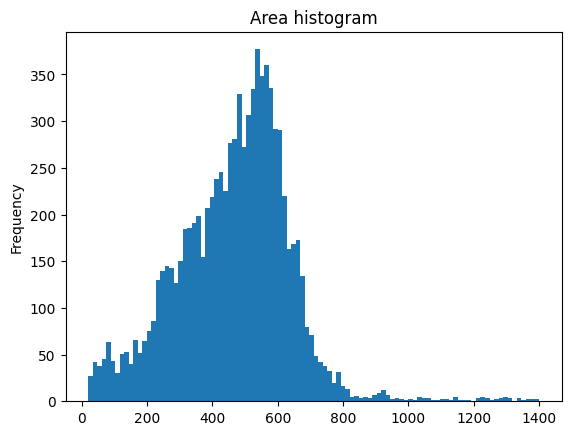

In [10]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [11]:
config.segmentation_config.min_area = 50
config.segmentation_config.max_area = 950
config.segmentation_config.n_workers = 8

The remaining parameters are harder to estimate without ground-truth data, hence they were tuned by trial and error.
From our experience setting the `power` parameter to 3 or 4 yields better results, specially in challenging scenarios. Note that, you must adjust the other `*_weight` accordingly when `power` is updated.

In [12]:
config.linking_config.max_distance = 25
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0

pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite'),
│   reader_config=ReaderConfig(reader_plugin='builtins', layer_indices=[0, 1]),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=50,
│   │   max_area=950,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7fc554423280>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(n_workers=8, max_neighbors=10, max_distance=25),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-1,
│   │   disappear_weight=-1,
│   │   division_weight=-0.1,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.0,
│   │   time_limit=36000,
│   │   method=-1,
│   │   n_threads=0,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.001
│   )
)

Now, we only need to execute the `segment`, `link`, and `track` functions and provide `data_config` and their respective configuration file.

In [13]:
segment(
    detection=detection,
    edge=edges,
    segmentation_config=config.segmentation_config,
    data_config=config.data_config,
    overwrite=True,
)

Adding nodes to database: 100%|█| 92/92 [00:13<00:00,  6.6


In [14]:
link(linking_config=config.linking_config, data_config=config.data_config, overwrite=True)

Linking nodes.: 100%|█████| 91/91 [00:02<00:00, 35.58it/s]


In [15]:
track(tracking_config=config.tracking_config, data_config=config.data_config, overwrite=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-04
Set parameter TimeLimit to value 36000
Set parameter MIPGap to value 0
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 29458 rows, 50766 columns and 94109 nonzeros
Model fingerprint: 0x1f154d3b
Variable types: 0 continuous, 50766 integer (50766 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 29456 rows and 50762 columns
Presolve time: 0.91s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 3150.1326586
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.93 seconds (0.37 work units)
Thread count was 16 (of 16 available processors)

Solutio

gurobi_solver.py (216): In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


The `to_tracks_layer` and `tracks_to_zarr` export the solution into a napari compatible format.

In [16]:
tracks_df, graph = to_tracks_layer(config.data_config)
labels = tracks_to_zarr(config.data_config, tracks_df)

Exporting segmentation masks: 100%|█| 92/92 [00:00<00:00, 


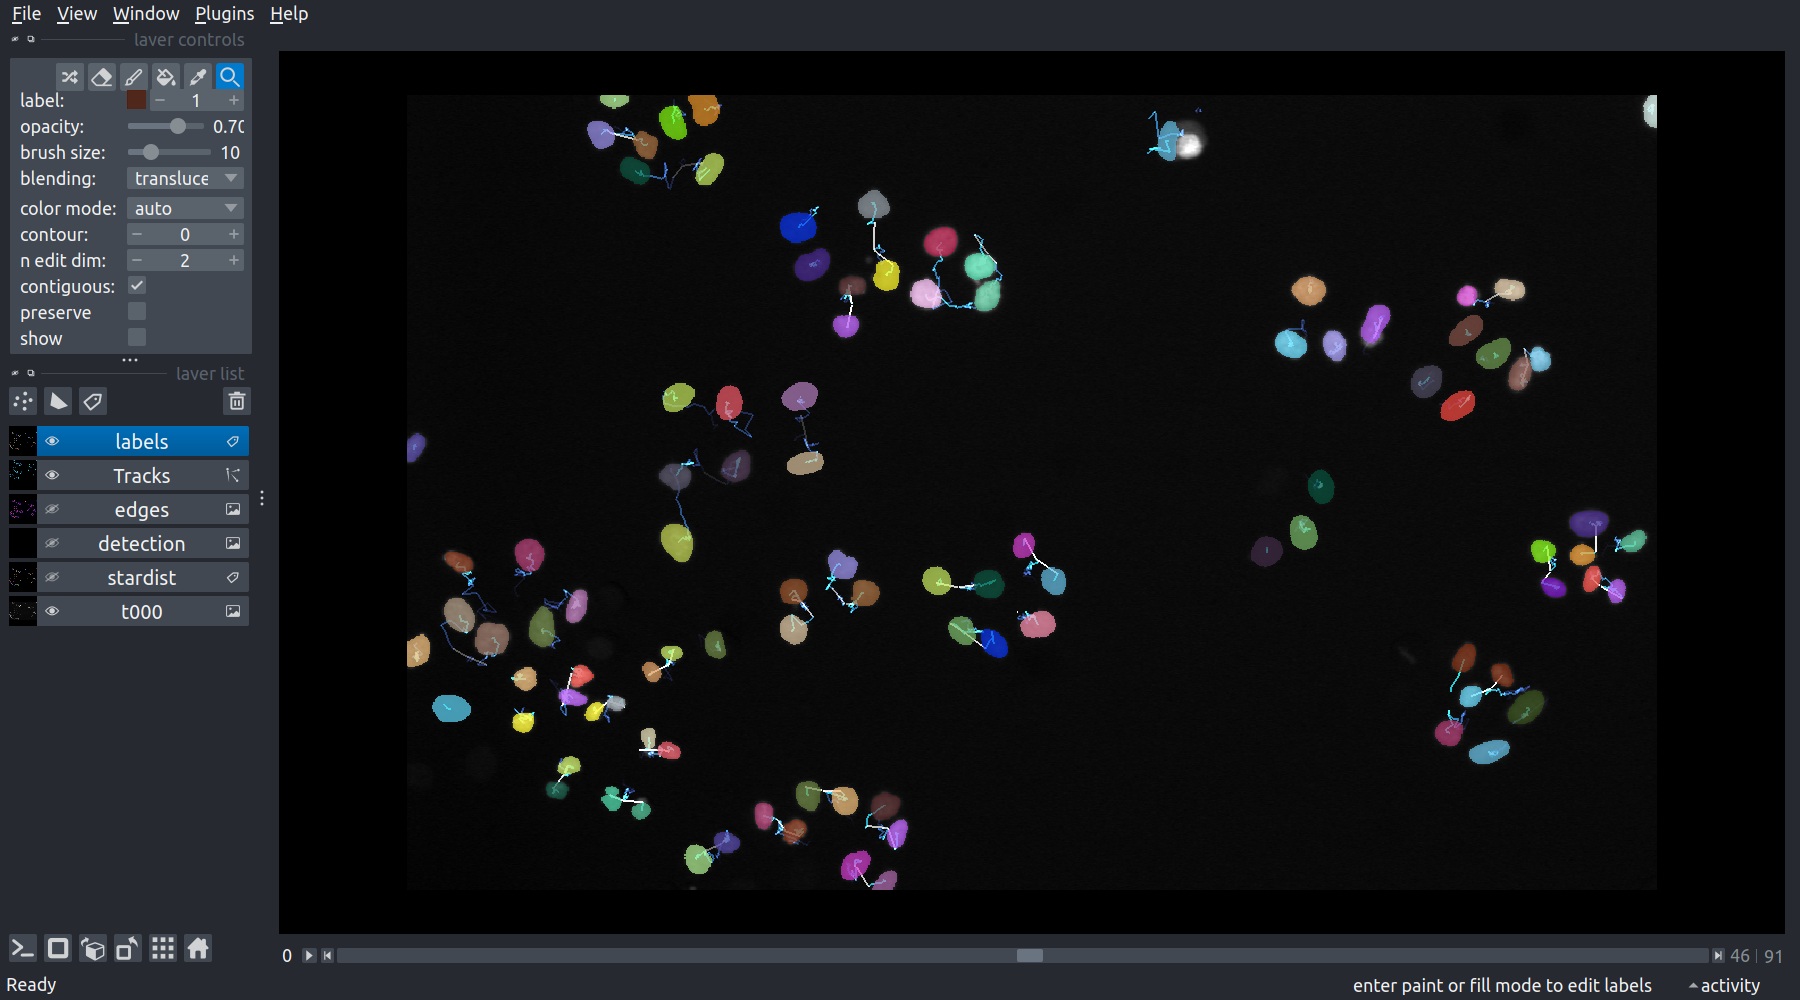

In [17]:
viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

viewer.layers["stardist"].visible = False
viewer.layers["edges"].visible = False

nbscreenshot(viewer)